In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
import matplotlib.pyplot as plt
import h5py
import numpy as np
import get_xyz
import constants
from pathlib import Path
import hdf5plugin
import streak_finder as sf
import add_geometry_streaks
import scipy.constants as sc

In [2]:
!h5ls -r /sf/bernina/exp/25g_chapman/work/streaks_ahmed/streaks_run0139.h5

/                        Group
/counts                  Dataset {603971}
/file_index              Dataset {77715}
/file_name               Dataset {603971}
/fs0_ss0_fs1_ss1_slab    Dataset {603971, 4}
/pulse_id                Dataset {77715, 1}
/streak_ids              Dataset {603971}


/tmp/ipykernel_2578404/3970391386.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels)


file='streakogram_Cu-Phthalocyanine_225.svg'


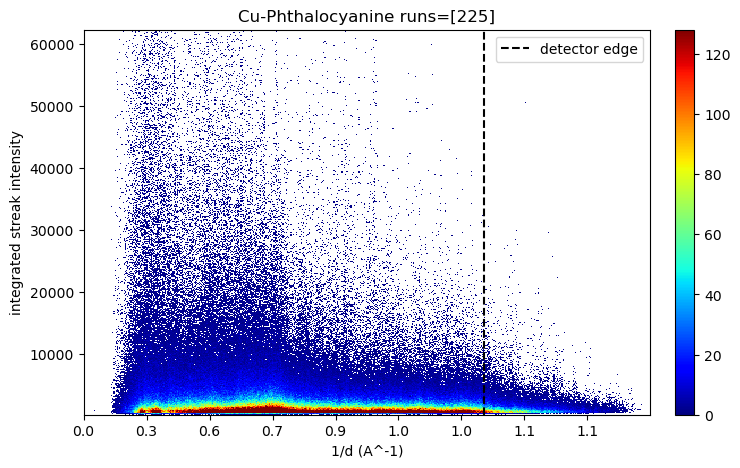

In [13]:
#runs = [65, 66, 67, 68, 69]
#title = f'I3C {runs=}'
#file = 'streakogram_I3C.svg'

runs = [176]
sample = 'Cu-Phthalocyanine'
title = f'{sample} {runs=}'
file = f'streakogram_{sample}.svg'

runs = [225]
sample_name = 'Cu-Phthalocyanine-last'

# runs = [227]
# sample_name = 'Vit-B12-recryst-1'

title = f'{sample} {runs=}'
file = f'streakogram_{sample}_{'-'.join([str(r) for r in runs])}.svg'

# runs = [126]
# sample = 'B3C_03'
# title = f'{sample} {runs=}'
# file = f'streakogram_{sample}.svg'

#runs = [78]
#sample = 'Ferritin_D1'
#title = f'{sample} {runs=}'
#file = f'streakogram_{sample}.svg'


#fnams = [Path(constants.work) / f'streaks/streaks_run{run:>04}.h5' for run in runs]
fnams = [Path(constants.work) / f'streaks/streaks_run{run:>04}.h5' for run in runs]

def calc_res(x, z, wav):
    return (x**2 + (z-(x**2 + z**2)**0.5)**2)**0.5 / (x**2 + z**2)**0.5 / wav

streaks = []
counts = []
for fnam in fnams:
    with h5py.File(fnam) as f:
        streaks.append(f['fs0_ss0_fs1_ss1_im'][()])
        counts.append(f['counts'][()])
    
streaks = np.concatenate(streaks, axis=0)
counts = np.concatenate(counts, axis=0)

# log scale
# counts = np.log10(counts)

# scale to meters
pixel_size = 75e-6
streaks *= pixel_size

# get centre of each streak
x = (streaks[:, 0] + streaks[:, 2])/2
y = (streaks[:, 1] + streaks[:, 3])/2
r = (x**2 + y**2)**0.5

# scale to resolution
z = 0.08 # detector distance
E = 12.4 # keV
wav = sc.h * sc.c / (E * sc.e * 1e3)
res = 1e-10 * calc_res(r, z, wav)

# edge distance of detector
xx, yy = get_xyz.get_xy_map()[:2]
edge = pixel_size * min(np.abs(xx).max(), np.abs(yy).max())
edge_res = 1e-10 * calc_res(edge, z, wav)
corner = pixel_size * np.max((xx**2 + yy**2)**0.5)
corner_res = 1e-10 * calc_res(corner, z, wav)

# h, bins = np.histogram(r, bins=1000)
range_im = range = [[0, corner], [counts.min(), np.percentile(counts, 99.5)]]

# range_im = range = [[0, edge], [0, counts.max()]]
H, binsx, binsy = np.histogram2d(r, counts, bins=500, range=range_im)
vmax = np.percentile(H[H>0], 98)
H[H==0] = np.nan
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
im = ax.imshow(H.T, origin='lower', vmin=0, vmax=vmax, cmap='jet', extent=[binsx[0], binsx[-1], binsy[0], binsy[-1]], aspect='auto', interpolation='none')

# relable x-axis with resolution
xlabels = ax.get_xticklabels()
for l in xlabels:
    x = l.get_position()[0]
    res_l = 1e-10 * calc_res(x, z, wav)
    text = str(round(res_l, 1))
    l.set_text(text)
ax.set_xticklabels(xlabels)

ylim = ax.get_ylim()

ax.vlines(edge, ylim[0], ylim[1], label='detector edge', color='k', linestyles='--')
# ax.vlines(corner, ylim[0], ylim[1], label='detector corner')
ax.legend()

ax.set_ylabel('integrated streak intensity')
ax.set_xlabel('1/d (A^-1)')    
ax.set_title(title)
plt.colorbar(im, fraction=0.046, pad=0.04)
print(f'{file=}')
plt.savefig(file)
plt.show()

In [10]:
pixel_size

7.5e-05